In [1]:
%matplotlib widget
from helper import *

<h1>Dual Quaternion Differential Kinematics</h1>

Differential Kinematics are an important concept in the field of robotics and automatin, dealing with the relationship between the joint velocity of the cobot and of its end effector or tool. This realationship is essential for controlling the motion of the cobot, particularly in tasks that require the path tracking in cartesian space. 

To derive the differential kinematics, first the cobots forward kinematics have to be defined, this is done on the example of MAiRA from Neura Robotics GmbH. These forward kinematics are then used to compute the matrix entries of the jacobian matrix $J$ which plays a pivotal role in the differential kinematics. The jacobian matrix provides a linear mapping between the joint velocoties and end-effektor velocities in the robots workspace, which is inversely used in practice to find the desired joint positions and velocities given a desired trajectory in cartesian space.

The study of differential kinematics not only facilitates the understanding of the velocity kinematics of the robots motion, but also gives insights about the analysis of kinematic singularities and dexterity. Kinematic singularities are configurations of the cobot where the jacobian loses rank, and certain end-effector velocities become infeasible, which is critical for path planning and execution. 

In contrary to many classical approaches, the differential kinematics will be defined in the dual quaternion space $\mathbb{H}$ to lever the benefits of dual quaternion algebra and the lack of representative singularities.

In the context of this Thesis the differential kinematics play an important role as they are used in the newly developed advanced control methods which invole the model predictive controller (MPC).

<h2>Screw Theoretic Forward Kinematics</h2>

- replace picture with nicer more technical picture
- find way to reference figure and table
- maybe write a bit about DH too

The fact that a screw transformation rotates any frame multiplied with the respecitve screw axis exponential map around the screw axis, can be leveraged to construct forward kinematics of a cobot. 
As presented by <cite id="7hdpn"><a href="#zotero%7C16222978%2FUIFPWU6T">(Lynch &#38; Park, 2017)</a></cite> for the case of matrix exponentials, for the forward kinematics, each joint is represented by a screw axis, defined by its orientation and position in space. These parameters are relative to the base coordinate system, in a defined and constant home position $\underline{M}$. The homeposition and the position and orientation of the screw axis on the example of maira can be seen in Fig 3.2.1.

<img src="./Resources/maira_screw_axis.png" alt="calibration scheme" style="max-width: 600px; width: 100%; display: block; margin-left: auto; margin-right: auto;margin-top: 10px;">
<p style="text-align: center; font-style: italic; margin-top: 10px;">MAiRA robot.</p>
    

The home position typically defined as the spatial transformation returned by the forward kinematics if all joint angles are set to zero, but can be chosen freely in practice. The corresponding positions and orientations of the screws as defined in the base frame of the robot can be found in table 3.1.

<table>
    <thead>
      <tr>
        <th>Link</th>
        <th>rotation axis</th>
        <th>position</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>1</td>
        <td>$(0,0,1)$</td>
        <td>$(0,0,0)$</td>
      </tr>
      <tr>
        <td>2</td>
        <td>$(0,1,0)$</td>
        <td>$(0,0,0.438)$</td>
      </tr>
      <tr>
        <td>3</td>
        <td>$(0,0,1)$</td>
        <td>$(0,0,0.438)$</td>
      </tr>
      <tr>
        <td>4</td>
        <td>$(0,1,0)$</td>
        <td>$(0,0,1.138)$</td>
      </tr>
      <tr>
        <td>5</td>
        <td>$(0,0,1)$</td>
        <td>$(0,0,1.138)$</td>
      </tr>
      <tr>
        <td>6</td>
        <td>$(0,1,0)$</td>
        <td>$(0,0,1.838)$</td>
      </tr>
      <tr>
        <td>7</td>
        <td>$(0,0,1)$</td>
        <td>$(0,0,1.838)$</td>
      </tr>
    </tbody>
  </table>
  
with the screws $\bar{\underline{s}}_i$ constructed from the table and the joint angles $\theta_i$ the unit dual quaternionic screw transformations can be defined: 

$$
\underline{\xi}_i = e^{\frac{\theta_i}{2}\bar{\underline{s}}_i} 
$$

with these transformations we can then define the transformation between the baseframe and the TCP:

$$ 
{}_0\underline{\xi}^{TCP} = (\Pi_{i = 0}^{n = 7} \underline{\xi}_i) \underline{M}
$$

The homemposition $\underline{M}$ is the transformed frame, it is rotated sucessively around each screw and represents the TCP transformation ${}_0\underline{\xi}^{TCP}$. For this example we choose the flange position of Maira, but any transformation could be given. The following code example shows how to set up the screw theory forward kinematics for MAiRA.

In [2]:
s1 = DualQuaternion.screwAxis(0,0,1, 0,0,0)
s2 = DualQuaternion.screwAxis(0,1,0, 0,0,0.438)
s3 = DualQuaternion.screwAxis(0,0,1, 0,0,0.438)
s4 = DualQuaternion.screwAxis(0,1,0, 0,0,1.138)
s5 = DualQuaternion.screwAxis(0,0,1, 0,0,1.138)
s6 = DualQuaternion.screwAxis(0,1,0, 0,0,1.838)
s7 = DualQuaternion.screwAxis(0,0,1, 0,0,1.838)

screws = [s1, s2, s3, s4, s5, s6, s7]

M_flange = DualQuaternion.fromQuatPos(Quaternion(1,0,0,0), [0,0,1.953])

def forward_kinematics(theta, screws_0, M):
    x = DualQuaternion.basicConstructor(1,0,0,0, 0,0,0,0)
    for i in range(len(theta)):
        x = x*DualQuaternion.exp(0.5*theta[i]*screws_0[i])
    
    return x*M

theta_example = [0, 0.2, 0.0, 1.56, -0.4, 1.6, 2]

x_0_TCP = forward_kinematics(theta_example, screws, M_flange)
print(x_0_TCP)

DualQuaternion(Real: Quaternion(0.109, 0.811, 0.540, -0.197), Dual: Quaternion(-0.226, -0.192, 0.437, 0.283))


<h2>The Jacobian</h2>

- rename jacobian to $J_\Omega$ or something, explain twist is different from cartesian velocity

Screw Theory allows for an efficient and elegant way to compute the jacobian matrix $J$, when compared to classical Methods. Here, often numerical algorithms like shown in <cite id="5y8oq"><a href="#zotero%7C16222978%2F3S984H2Z">(Yazdanpanah Abdolmalaki, 2017)</a></cite> are chosen, which involve the extraction of the rotation axes from the robots kinematic model, which define the rotational part of $J$ and a cross product computation for the translational part. In screw theory the columns of $J$ are transformed screws. In <cite id="c1wxs"><a href="#zotero%7C16222978%2FUIFPWU6T">(Lynch &#38; Park, 2017)</a></cite> general forward and velocity kinematics are differentiated into either <i>Body</i> or <i>Space</i> representation, the representation chosen for the thesis is the space representation. It differs mathematically from the geometric jacobian often used classical approaches, but can be applied in the same way practically, if the space representation is chosen coherently for the velocity representation in the case of differential kinematics, or the error computation in the case of inverse kinematics.

To find the space jacobian $J$, the line transformation operation and the exponential mapping of unit dual quaternions are needed. The computation can be found in the following code block.


In [3]:
def jacobian(theta, screws_0):
    
    # initialize transformation as identity transformation
    x = DualQuaternion.basicConstructor(1,0,0,0, 0,0,0,0)
    
    # initialize jacobian with zeros
    J = np.zeros((8, len(theta)))
    
    # loop over all joints
    for i in range(len(theta)):
        
        # get screw (defined in base frame) from list
        s_0 = screws_0[i]
        
        #transform screw with the line transformation
        s_i = x*s_0*x.inverse()
        
        # progress transformation with screw and joint angle
        x = x*DualQuaternion.exp(0.5*theta[i]*s_0)
        
        # assign transformed screw to Jacobian row
        J[:, i] = s_i.asVector().flatten()
    
    return J

J = jacobian(theta_example, screws)
print(J)

[[   0.000    0.000    0.000    0.000    0.000   -0.000    0.000]
 [   0.000    0.000    0.199    0.000    0.982   -0.073   -0.202]
 [   0.000    1.000    0.000    1.000    0.000    0.921   -0.389]
 [   1.000    0.000    0.980    0.000   -0.188   -0.382   -0.899]
 [   0.000    0.000    0.000    0.000    0.000    0.000    0.000]
 [   0.000   -0.438    0.000   -1.124    0.000   -0.914    0.386]
 [   0.000    0.000    0.087    0.000    1.130    0.243    0.543]
 [   0.000    0.000    0.000    0.139    0.000    0.761   -0.322]]


Note that the Jacobian from this algorithm has the dimensionality of $J \in \mathbb{R}^{8 \times DoF}$, which is caused by the quaternion dimension of eight. Whether the matrix should be $6 \times DoF$ or $8 \times DoF$ can be chosen depending on the use case. If the classic form factor is needed, the exclusion of the first and fith row will result in $J \in \mathbb{R}^{6 \times DoF}$

Besides the elegant and efficient computation, another benefit of the screw theoretic contemplation is that higher derivatives of $J$ are very easy and efficiently computeable when compared to classical approaches like the one found in <cite id="tbcfd"><a href="#zotero%7C16222978%2F63SGHUSV">(Angeles, 2014)</a></cite>. An example for the first jacobian derivative $\dot{J}$ can be seen in the next code block. Note that we leverage the algebraic property of the exponential function to compute the screw transformation derivative, which is needed to find the derivative of the screw axis w.r.t time.
 
$$
\frac{d}{dt} \left(e^{\frac{\theta_i}{2}\underline{\bar{s}}_i}\right) =  e^{\frac{\theta_i}{2}\underline{\bar{s}}_i} \otimes \frac{\dot{\theta}_i}{2}\underline{\bar{s}}_i
$$

The resulting Algorithm can be easily extended to further derivatives by application of the chain rule of differentiation. A unique feature of the screw theory approach!

In [4]:
def jacobian_dot(theta, theta_dot, screws_0):
    
    # initialize transformation as identity transformation
    x = DualQuaternion.basicConstructor(1,0,0,0, 0,0,0,0)
    
    # initialialize transformation derivative as zero
    x_dot = DualQuaternion.basicConstructor(0,0,0,0, 0,0,0,0)
    
    # initialize Jacobian derivative with zeros
    J_dot = np.zeros((8, len(theta)))
    
    # loop over all joints
    for i in range(len(theta)):
        # get screw (defined in base frame) from list
        s_0 = screws_0[i]
        
        #compute screw derivative and transform
        s_i_dot = x_dot*s_0*x.inverse() + x*s_0*x_dot.inverse()
        
        # compute temporary transformation via exponential map
        x_temp = DualQuaternion.exp(0.5*theta[i]*s_0)
        
        # compute temporary transformation derivative via exponential derivative
        x_dot_temp = DualQuaternion.exp(0.5*theta[i]*s_0)*(0.5*theta_dot[i]*s_0)
        
        # update transformation derivative
        x_dot = x_dot*x_temp + x*x_dot_temp
        
        # update transformation
        x = x*x_temp
        
        #assign screw derivative to jacobian derivative row
        J_dot[:, i] = s_i_dot.asVector().flatten()
    
    return J_dot

theta_dot = np.array([1, 1, 1, 2, 2, 2, 3])

print(jacobian_dot(theta_example, theta_dot, screws))

[[   0.000    0.000    0.000    0.000    0.000    0.000    0.000]
 [   0.000   -1.000    0.980   -1.980   -0.564   -2.625   -4.025]
 [   0.000    0.000    0.199    0.000    1.982    0.710    1.643]
 [   0.000    0.000   -0.199    0.199   -2.946    2.212    0.192]
 [   0.000    0.000    0.000    0.000    0.000   -0.000    0.000]
 [   0.000    0.000   -0.087    0.139   -2.254    0.740   -3.859]
 [   0.000   -0.438    0.429   -2.253   -0.232   -4.161   -3.448]
 [   0.000    0.000    0.000    0.686    0.139    0.967    1.553]]


<h2>The Jacobian in Dual Quaternion Space $\mathbb{H}$</h2>

The Jacobian relates changes in workspace and joint space. There are multiple ways how the workspace change (i.e. TCP-velocity) might be defined, e.g., rotational and translational velocites $(\vec{\omega}, \vec{v})$, twist $\vec{\Omega}$ or the dual quaternion derivative $\underline{\dot{\xi}}$. As the goal of the thesis is to leverage the dual quaternion algebra, it will be tested to compute the differential kinematics in the dual quaternion space $\mathbb{H}$. This needs a transformation of the space jacobian $J$, which is twist based:

$$
\vec{\Omega} = J \dot{\vec{\theta}}
$$

For this transformation into the dual quaternion space, the relation of the twist and the dual quaternion derivative is recalled. 

$$
\begin{align*}
\underline{\dot{\xi}} &= \frac{1}{2} \underline{\bar{\Omega}} \otimes \underline{\xi}\\
&= \frac{1}{2} [\underline{\xi}]_R \cdot \underline{\bar{\Omega}}_{[vec]}
\end{align*}
$$

In case $J \in \mathbb{R}^{8 \times DoF}$, then $\underline{\bar{\Omega}}_{[vec]} = \vec{\Omega}$, which allows substitution of the twist with $J \dot{\vec{\theta}}$. Reformulation then gives the unit dual quaternion jacobian $J_\mathbb{H}$:

$$
\begin{align*}
\underline{\dot{\xi}} &= \left(\frac{1}{2} [\underline{\xi}]_R J \right) \dot{\vec{\theta}}\\
&= J_\mathbb{H}\dot{\vec{\theta}}
\end{align*}
$$

as chosen before, the dimensionality of the newly derived jacobian is $J_\mathbb{H} \in \mathbb{R}^{8 \times DoF}$ which extends the normal six dimensional cartesian space by two further dimensions which are purely imaginary. In <cite id="1vvyz"><a href="#zotero%7C16222978%2FAFEHQ7QJ">(Dantam, 2021)</a></cite> this dual quaternion jacobian is used to solve the position level inverse kinematics which leverages the efficient and elegant unit dual quaternion algebra to speed up the optimization compared to the classical implementation of "TRACK-IK" <cite id="slo2p"><a href="#zotero%7C16222978%2FCX5ZL77E">(Beeson &#38; Ames, 2015)</a></cite>. 

<h1> Benefits of Dual Quaternion Jacobian </h1>

- write either here or in results?
- better convergence, less iterations
- a lot more robust for larger errors in q_guess

sucess rate classic IK:  100.0 %
sucess rate DQ IK:  100.0 %
average num of iterations for classic IK:  4.056
average num of iterations for DQ IK:  4.1


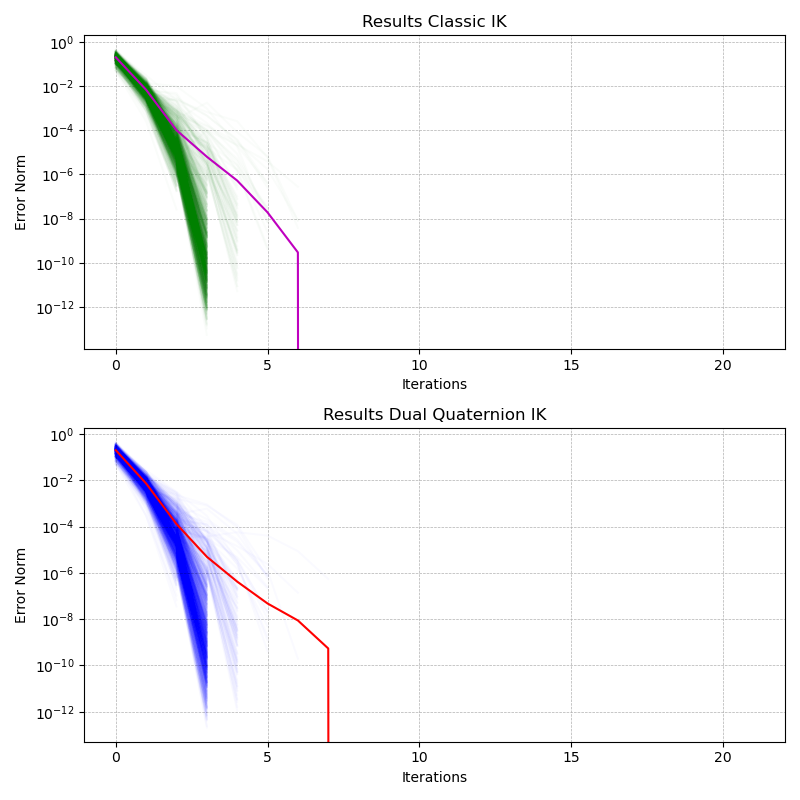

In [8]:
import numpy as np
from Simulation.ForwardKinematics import ForwardKinematics
from Simulation.InverseKinematics import InverseKinematics
import matplotlib.pyplot as plt

min_lim = np.array([-np.pi, -120*np.pi/180, -150*np.pi/180, -np.pi, -np.pi, -np.pi])
max_lim = np.array([np.pi, 120*np.pi/180, 150*np.pi/180, np.pi, np.pi, np.pi])

fk = ForwardKinematics() 
ik = InverseKinematics(min_lim, max_lim)

num_eval = 1000
success_count_classic = 0
success_count_DQ = 0
error_list_DQ = []
error_list_classic = []
for i in range(num_eval):
    q_guess = getRandomJointAngles()
    
    x_target = fk.getFK(perturbJointAngles(q_guess, 5))

    q_sol_classic, error_norm_classic, condition_classic, success_classic = ik.getIK_classic(x_target, q_guess, 0.001)
    q_sol_DQ, error_norm_DQ, condition_DQ, success_DQ = ik.getIK_DQ(x_target, q_guess, 0.001)
    
    error_list_DQ.append(error_norm_DQ)
    error_list_classic.append(error_norm_classic)
    
    if success_classic:
        success_count_classic += 1
    if success_DQ:
        success_count_DQ += 1
        

plotIKResults(error_list_classic, error_list_DQ, success_count_classic, success_count_DQ, num_eval)

sucess rate classic IK:  97.4 %
sucess rate DQ IK:  98.7 %
average num of iterations for classic IK:  8.97
average num of iterations for DQ IK:  8.762


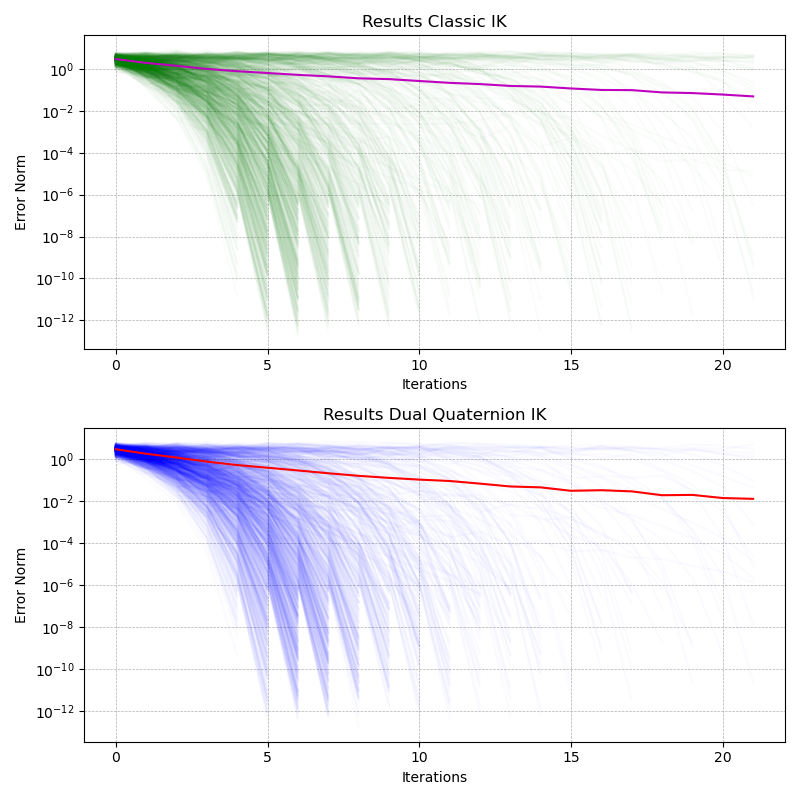

In [10]:
import numpy as np
from Simulation.ForwardKinematics import ForwardKinematics
from Simulation.InverseKinematics import InverseKinematics
import matplotlib.pyplot as plt

min_lim = np.array([-np.pi, -120*np.pi/180, -150*np.pi/180, -np.pi, -np.pi, -np.pi])
max_lim = np.array([np.pi, 120*np.pi/180, 150*np.pi/180, np.pi, np.pi, np.pi])

fk = ForwardKinematics() 
ik = InverseKinematics(min_lim, max_lim)

num_eval = 1000
success_count_classic = 0
success_count_DQ = 0
error_list_DQ = []
error_list_classic = []
for i in range(num_eval):
    q_guess = getRandomJointAngles()
    
    x_target = fk.getFK(perturbJointAngles(q_guess, 85))

    q_sol_classic, error_norm_classic, condition_classic, success_classic = ik.getIK_classic(x_target, q_guess, 0.001)
    q_sol_DQ, error_norm_DQ, condition_DQ, success_DQ = ik.getIK_DQ(x_target, q_guess, 0.001)
    
    error_list_DQ.append(error_norm_DQ)
    error_list_classic.append(error_norm_classic)
    
    if success_classic:
        success_count_classic += 1
    if success_DQ:
        success_count_DQ += 1
        

plotIKResults(error_list_classic, error_list_DQ, success_count_classic, success_count_DQ, num_eval)

<h1> Literature </h1>
<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry"><i id="zotero|16222978/63SGHUSV"></i>Angeles, J. (2014). <i>Fundamentals of Robotic Mechanical Systems: Theory, Methods, and Algorithms</i> (Vol. 124). Springer International Publishing. <a href="https://doi.org/10.1007/978-3-319-01851-5">https://doi.org/10.1007/978-3-319-01851-5</a></div>
  <div class="csl-entry"><i id="zotero|16222978/CX5ZL77E"></i>Beeson, P., &#38; Ames, B. (2015). TRAC-IK: An open-source library for improved solving of generic inverse kinematics. <i>2015 IEEE-RAS 15th International Conference on Humanoid Robots (Humanoids)</i>, 928–935. <a href="https://doi.org/10.1109/HUMANOIDS.2015.7363472">https://doi.org/10.1109/HUMANOIDS.2015.7363472</a></div>
  <div class="csl-entry"><i id="zotero|16222978/AFEHQ7QJ"></i>Dantam, N. T. (2021). Robust and efficient forward, differential, and inverse kinematics using dual quaternions. <i>The International Journal of Robotics Research</i>, <i>40</i>(10–11), 1087–1105. <a href="https://doi.org/10.1177/0278364920931948">https://doi.org/10.1177/0278364920931948</a></div>
  <div class="csl-entry"><i id="zotero|16222978/UIFPWU6T"></i>Lynch, K. M., &#38; Park, F. C. (2017). <i>Modern robotics: mechanics, planning, and control</i>. Cambridge University Press.</div>
  <div class="csl-entry"><i id="zotero|16222978/3S984H2Z"></i>Yazdanpanah Abdolmalaki, R. (2017). <i>Geometric Jacobians Derivation and Kinematic Singularity Analysis for Smokie Robot Manipulator &#38; the Barrett WAM</i>.</div>
</div>
<!-- BIBLIOGRAPHY END -->